### Ergodic control with the Fourier ergodic metric

Reference: 

*Miller, Lauren M., et al*. "[Ergodic exploration of distributed information](https://ieeexplore.ieee.org/document/7350162)." IEEE Transactions on Robotics 32.1 (2015): 36-52.

For more examples on ergodic control, please also visit the [ergodic control sandbox](https://github.com/MurpheyLab/ergodic-control-sandbox).

In [1]:
import jax 
import jax.numpy as jnp 
from jax import vmap, jit, grad
from jax.scipy.stats import multivariate_normal as mvn

cpu = jax.devices("cpu")[0]
try:
    gpu = jax.devices("cuda")[0]
except:
    gpu = cpu

import numpy as np
import matplotlib.pyplot as plt 

try:
    from lqrax.discrete import iLQR
except:
    %pip install lqrax
    from lqrax.discrete import iLQR

In [2]:
class PointAgent(iLQR):
    def __init__(self, x_dim, u_dim, Q, R):
        super().__init__(x_dim, u_dim, Q, R)

    def dyn(self, xt, ut):
        dt = 0.01
        A = jnp.array([
            [1.0, 0.0, dt, 0.0],
            [0.0, 1.0, 0.0, dt],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])
        B = jnp.array([
            [0.5 * dt**2, 0.0],
            [0.0, 0.5 * dt**2],
            [dt, 0.0],
            [0.0, dt]
        ])
        return A @ xt + B @ ut

In [3]:
Q_point = jnp.diag(jnp.array([0.1, 0.1, 0.001, 0.001]))
R_point = jnp.diag(jnp.array([0.01, 0.01]))

tsteps = 1000

point_ilqr = PointAgent(x_dim=4, u_dim=2, Q=Q_point, R=R_point)

linearize_dyn = jit(point_ilqr.linearize_dyn, device=cpu)
solve_ilqr = jit(point_ilqr.solve, device=cpu)

In [4]:
# Define the target distribution for coverage
def pdf(x):
    mean1 = jnp.array([0.35, 0.38])
    mean2 = jnp.array([0.68, 0.25])
    mean3 = jnp.array([0.56, 0.64])
    cov1 = jnp.array([
        [0.01, 0.004],
        [0.004, 0.01]
    ])
    cov2 = jnp.array([
        [0.005, -0.003],
        [-0.003, 0.005]
    ])
    cov3 = jnp.array([
        [0.008, 0.0],
        [0.0, 0.004]
    ])
    w1, w2, w3 = 0.5, 0.2, 0.3
    return w1 * mvn.pdf(x, mean1, cov1) + \
        w2 * mvn.pdf(x, mean2, cov2) + \
        w3 * mvn.pdf(x, mean3, cov3)


# Define a 1m-by-1m 2D search space
grids_x, grids_y = np.meshgrid(
    np.linspace(0, 1.0, 100),
    np.linspace(0, 1.0, 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = grids_x[0, 1] - grids_x[0, 0]
dy = grids_y[1, 0] - grids_y[0, 0]

In [5]:
# Define Fourier ergodic metric
numk = 10  # number of basis functions (each dimension)
ks_1, ks_2 = jnp.meshgrid(jnp.arange(numk), jnp.arange(numk))
ks = jnp.array([ks_1.ravel(), ks_2.ravel()]).T  # basis index vectors
lamks = jnp.power(1.0 + jnp.linalg.norm(ks, axis=1), -3/2.0)  # convergent weights
fk_grids = jnp.prod(jnp.cos(jnp.pi * ks * grids[:, None]), axis=-1)  
hks = jnp.sqrt(jnp.sum(jnp.square(fk_grids), axis=0) * dx * dy)  # normalization terms

tgt_distr = vmap(pdf)(grids)
tgt_distr /= jnp.sum(tgt_distr) * dx * dy
phiks = jnp.sum(fk_grids / hks * tgt_distr[:, None], axis=0) * dx * dy  # target coefficients


# Define a barrier function to make sure the robot stays in the search space
def barr(x_traj):
    def barr_xt(xt):
        penalty_high = jnp.maximum(xt[:2] - 0.95, 0.0)
        penalty_low = jnp.maximum(0.05 - xt[:2], 0.0)
        val = jnp.sum(jnp.square(penalty_high)) + \
            jnp.sum(jnp.square(penalty_low))
        return val
    barr_traj = jax.vmap(barr_xt)(x_traj)
    return jnp.sum(barr_traj)


# Define the Fourier ergodic metric
def fourier_metric(x_traj):
    fk_traj = jnp.prod(
        jnp.cos(jnp.pi * ks * x_traj[:, :2][:, None]), axis=-1)
    cks = jnp.mean(fk_traj / hks, axis=0)
    loss = jnp.sum(lamks * jnp.square(cks - phiks))
    return loss + barr(x_traj)


# Autodiff the derivative of the Fourier ergodic metric
d_fourier_traj = grad(fourier_metric)

fourier_metric = jit(fourier_metric, device=gpu)
d_fourier_traj = jit(d_fourier_traj, device=gpu)

In [6]:
# initial conditions
x0 = jnp.array([0.2, 0.7, 0.0, 0.0])
u_traj = jnp.zeros((tsteps, 2))

In [7]:
def line_search(x0, u_traj, v_traj, step_sizes):
    u_traj_batch = u_traj[None, :, :] + \
        step_sizes[:, None, None] * v_traj[None, :, :]
    x_traj_batch = vmap(point_ilqr.traj_sim,
                        in_axes=(None, 0))(x0, u_traj_batch)
    x_traj_batch = jax.device_put(x_traj_batch, device=gpu)
    costs = vmap(fourier_metric)(x_traj_batch)
    return step_sizes[jnp.argmin(costs)]


line_search = jit(line_search, device=gpu)

step_sizes = jnp.power(10.0, jnp.linspace(-1.0, 1.0, 20))
num_iters = 100
for i in range(num_iters+1):
    x_traj, A_traj, B_traj = linearize_dyn(x0, u_traj)
    fourier_dx_traj = d_fourier_traj(x_traj)
    b_traj = jnp.zeros_like(u_traj)
    z0 = jnp.zeros(2)
    v_traj, z_traj = solve_ilqr(A_traj, B_traj, fourier_dx_traj, b_traj)
    step_size = line_search(x0, u_traj, v_traj, step_sizes)
    u_traj += float(step_size) * v_traj

    if i % int(num_iters/10) == 0:
        print(f'loss [{i:3d}/{num_iters}]: {fourier_metric(x_traj):7.4f} | step size: {step_size:3.2f}')

loss [  0/100]:  5.4748 | step size: 0.34
loss [ 10/100]:  0.0775 | step size: 1.83
loss [ 20/100]:  0.0420 | step size: 1.83
loss [ 30/100]:  0.0300 | step size: 3.79
loss [ 40/100]:  0.0209 | step size: 6.16
loss [ 50/100]:  0.0153 | step size: 6.16
loss [ 60/100]:  0.0132 | step size: 1.83
loss [ 70/100]:  0.0119 | step size: 2.98
loss [ 80/100]:  0.0107 | step size: 2.34
loss [ 90/100]:  0.0095 | step size: 6.16
loss [100/100]:  0.0086 | step size: 4.83


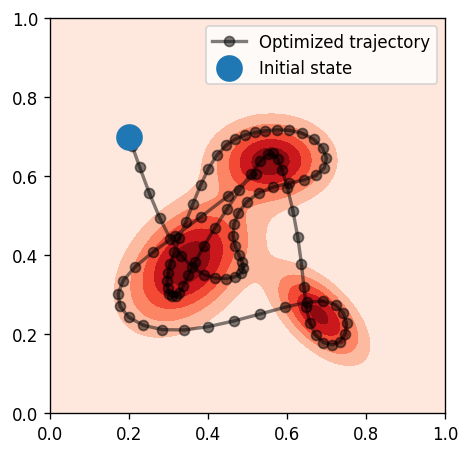

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120, tight_layout=True)

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.contourf(grids_x, grids_y, tgt_distr.reshape(grids_x.shape), cmap='Reds')
ax.plot([x0[0], x_traj[::10][0,0]], [x0[1], x_traj[::10][0,1]], linestyle='-', linewidth=2, color='k', alpha=0.5)
ax.plot(x_traj[::10][:,0], x_traj[::10][:,1], linestyle='-', marker='o', color='k', linewidth=2, alpha=0.5, label='Optimized trajectory')
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='C0', alpha=1.0, label='Initial state')
ax.legend()
plt.show()
plt.close()

In [9]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120, tight_layout=True)
imgs = []

def update(t):
    ax.cla()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.axis('off')
    ax.contourf(grids_x, grids_y, tgt_distr.reshape(grids_x.shape), cmap='Reds')

    ax.plot(x_traj[::10][:t,0], x_traj[::10][:t,1], linestyle='-', marker='o', color='k', linewidth=2, alpha=0.5)
    ax.plot(x_traj[::10][t,0], x_traj[::10][t,1], linestyle='', marker='o', markersize=15, color='C0', alpha=1.0)

    return []


ani = animation.FuncAnimation(fig, update, frames=len(x_traj[::10]), interval=50)
plt.close()
HTML(ani.to_html5_video())